<a href="https://colab.research.google.com/github/Superchileno/llueve-manana/blob/main/WeatherAustraliav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de lluvias con *machine learning*
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
***

**Contexto**

En este desafío realizaremos predicciones sobre si lloverá un día, en base a la información disponible del día anterior. Por tanto, en este desafío nos enfrentamos a un problema de clasificación.

Para este desafío, utilizaremos un conjunto de datos que contiene 10 años de observaciones meteorológicas diarias de múltiples zonas de Australia. En este dataset, `LlueveManana` es la etiqueta a predecir, donde los valores que puede tomar son `Si` o `No`, donde `Sí` significa que al día siguiente llueve y `No`, que al día siguiente no llueve.

**Datos y agradecimientos**

Las observaciones se extrajeron de numerosas estaciones meteorológicas. Las observaciones diarias están disponibles en http://www.bom.gov.au/climate/data.

Definiciones adaptadas de: [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)

**Fuentes de datos original**:

- Oficina de meteorología Australiana, *Daily Weather Observations*: [http://www.bom.gov.au/climate/dwo/](http://www.bom.gov.au/climate/dwo/)
- Oficina de meteorología Australiana, *Climate Data Online*: [http://www.bom.gov.au/climate/data](http://www.bom.gov.au/climate/data)

*Copyright Commonwealth of Australia 2010, Oficina de Meteorología.*

**Descripción de variables**:

Es importante destacar que para simplificar el desafío, se ha seleccionado un subconjunto de variables, descartando variables que no han mostrado mejorar el desempeño de los clasificadores. Lo anterior no significa que todas las variables que se presentan a continuación mejoren el desempeño de los clasificadores.

| Variable    | Descripción |
|:------------|:----------------------|
|Fecha        |Fecha de la observación|
|MinTemp      |Temperatura mínima para ese día (º Celsius)|
|MaxTemp      |Temperatura máxima para ese día (º Celsius)|
|LluviaHoy    |Cantidad de lluvia registrada para el día en milímetros (mm)|
|Presion9am   |Presión atmosférica (hpa) reducida al nivel medio del mar a las 9 a.m.|
|Presion3pm   |Presión atmosférica (hpa) reducida al nivel medio del mar a las 3 a.m.|
|Humedad9am   |Humedad a las 9 a.m (porcentual)|
|Humedad3pm   |Humedad a las 3 p.m (porcentual)|
|DirViento9am |Dirección del viento a las 9 a.m.|
|DirViento3pm |Dirección del viento a las 3 p.m.|
|LlueveManana |Indica si al siguiente día llueve o no|

A continuación, prepararemos nuestro ambiente de trabajo: importaremos las librerías necesarias para nuestra análisis y cargaremos los datos (notar que los datos están disponibles en github, por lo que pueden leer los datos directamente a través de url que aparece más abajo).
***

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ssantanar/datasets/master/weather_australia/weatherAUS_s.csv')
# transformamos la variable fecha de string a una en formato de fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])
# creamos la columna mes
df['Mes'] = df.Fecha.dt.month
print(f"Observaciones : {df.shape[0]:,}")
print(f"Columnas      : {df.shape[1]}")
df.head()

Observaciones : 117,058
Columnas      : 12


,Fecha,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,DirViento9am,DirViento3pm,LlueveManana,Mes
0,2007-11-01,8.0,24.3,0.0,1019.7,1015.0,68.0,29.0,SW,NW,Yes,11
1,2007-11-02,14.0,26.9,3.6,1012.4,1008.4,80.0,36.0,E,W,Yes,11
2,2007-11-03,13.7,23.4,3.6,1009.5,1007.2,82.0,69.0,N,NNE,Yes,11
3,2007-11-04,13.3,15.5,39.8,1005.5,1007.0,62.0,56.0,WNW,W,Yes,11
4,2007-11-05,7.6,16.1,2.8,1018.3,1018.5,68.0,49.0,SSE,ESE,No,11


In [5]:
# estadísticos descriptivos para nuestros datos
df.describe().round(2)

,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,Mes
count,117058.00,117058.00,117058.00,117058.00,117058.00,117058.00,117058.00,117058.00
mean,12.68,23.58,2.39,1017.45,1015.08,67.53,51.00,6.43
std,6.21,6.94,8.63,7.04,6.97,18.80,20.73,3.47
min,-8.20,2.60,0.00,980.50,977.10,0.00,0.00,1.00
25%,8.10,18.20,0.00,1012.80,1010.40,56.00,36.00,3.00
50%,12.40,23.00,0.00,1017.40,1015.10,69.00,52.00,6.00
75%,17.20,28.50,0.80,1022.20,1019.80,81.00,65.00,9.00
max,33.90,48.10,371.00,1041.00,1039.60,100.00,100.00,12.00


Notar que en `LluviaHoy` existe un valor significativamente mayor al resto de los valores en esa variable. Esto puede corresponder a un error en los datos o una anomalía climática. No obstante, para facilitar la interpretación de los valores, eliminaremos aquellos valores extremos en dicha variable.

In [6]:
# reemplazamos por NaN todos los valores mayores al valor en el percentil 99
df.loc[df.LluviaHoy>np.quantile(df.LluviaHoy, 0.99),'LluviaHoy'] = np.nan
# eliminamos las filas que posean valores perdidos (NaN)
df.dropna(inplace=True)
# estadísticos descriptivos para nuestros datos
df.describe().round(2)

,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,Mes
count,115888.00,115888.00,115888.00,115888.00,115888.00,115888.00,115888.00,115888.00
mean,12.63,23.58,1.75,1017.51,1015.13,67.33,50.75,6.44
std,6.20,6.95,4.74,7.01,6.94,18.76,20.62,3.47
min,-8.20,2.60,0.00,980.50,977.10,0.00,0.00,1.00
25%,8.10,18.20,0.00,1012.90,1010.40,56.00,36.00,3.00
50%,12.40,23.00,0.00,1017.50,1015.10,68.00,52.00,6.00
75%,17.10,28.50,0.60,1022.20,1019.80,81.00,65.00,9.00
max,33.90,48.10,37.80,1041.00,1039.60,100.00,100.00,12.00


In [7]:
# valores perdidos: notar que no hay valores perdidos
df.isna().sum()

Fecha           0
MinTemp         0
MaxTemp         0
LluviaHoy       0
Presion9am      0
Presion3pm      0
Humedad9am      0
Humedad3pm      0
DirViento9am    0
DirViento3pm    0
LlueveManana    0
Mes             0
dtype: int64

A continuación realizaremos un análisis exploratorio de los datos con el objetivo de identificar si existen tendencias, anomalías o patrones que nos puedan ayudar a entender mejor los datos:

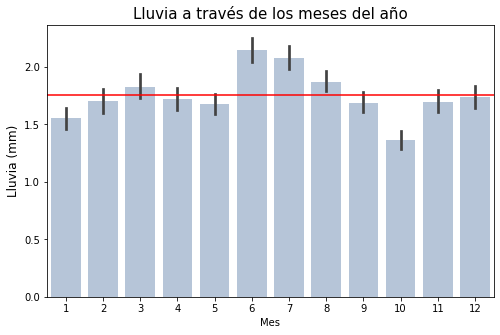

In [8]:
# plotting Rainfall per Month
plt.figure(figsize=(8,5))
ax = sns.barplot(x = 'Mes', y='LluviaHoy', data=df, color = 'lightsteelblue')
ax.set_title('Lluvia a través de los meses del año',fontsize=15)
ax.set_ylabel('Lluvia (mm)',fontsize=12)
ax.set_xlabel('Mes')
ax.axhline(y=np.mean(df['LluviaHoy']), color='red');

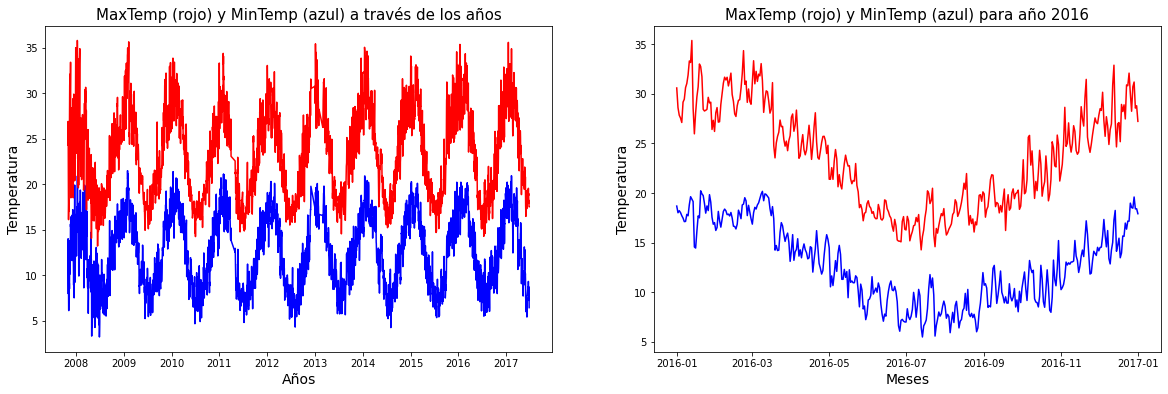

In [9]:
temp = df.groupby(['Fecha'])[['MinTemp','MaxTemp']].mean().reset_index()
fig, axes = plt.subplots(1,2,figsize=(20,6))
ax = sns.lineplot(data = temp, x='Fecha', y='MinTemp', color='b', ax=axes[0])
ax = sns.lineplot(data = temp, x='Fecha', y='MaxTemp', color='r', ax=axes[0])
ax.set_title('MaxTemp (rojo) y MinTemp (azul) a través de los años',fontsize=15)
ax.set_ylabel('Temperatura',fontsize=14)
ax.set_xlabel('Años',fontsize=14)
# serie para el año 2016
ax = sns.lineplot(data = temp[temp.Fecha.between('2016-01-01','2017-01-01')], x='Fecha', y='MaxTemp', color='r', ax=axes[1])
ax = sns.lineplot(data = temp[temp.Fecha.between('2016-01-01','2017-01-01')], x='Fecha', y='MinTemp', color='b', ax=axes[1])
ax.set_title('MaxTemp (rojo) y MinTemp (azul) para año 2016',fontsize=15)
ax.set_ylabel('Temperatura',fontsize=14)
ax.set_xlabel('Meses',fontsize=14);

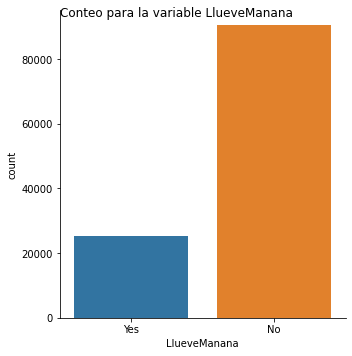

In [10]:
ax = sns.catplot(x = 'LlueveManana', kind = 'count', data = df)
ax.fig.suptitle('Conteo para la variable LlueveManana');

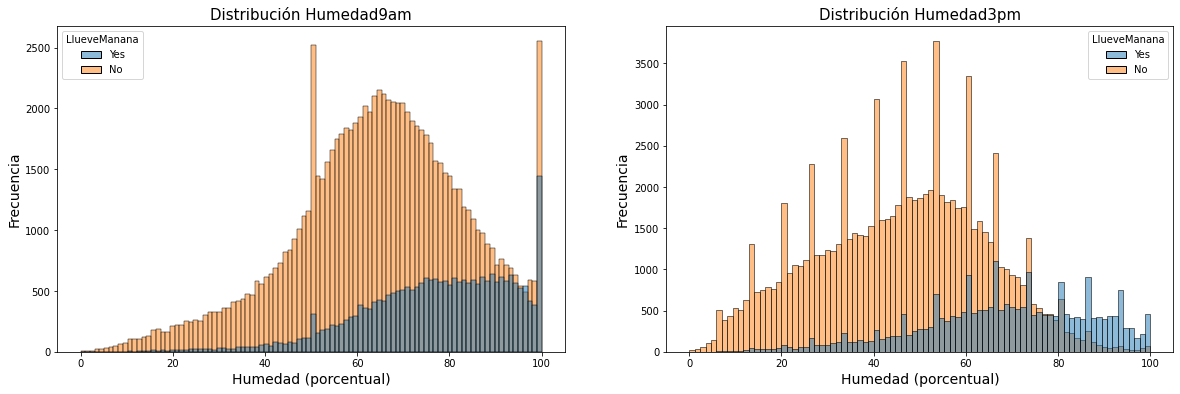

In [11]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
# distribucion para Humedad9am
ax = sns.histplot(data=df, x="Humedad9am", hue="LlueveManana", ax=axes[0])
ax.set_title('Distribución Humedad9am',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Humedad (porcentual)',fontsize=14)
# distribucion para Humedad3pm
ax = sns.histplot(data=df, x="Humedad3pm", hue="LlueveManana", ax=axes[1])
ax.set_title('Distribución Humedad3pm',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Humedad (porcentual)',fontsize=14);

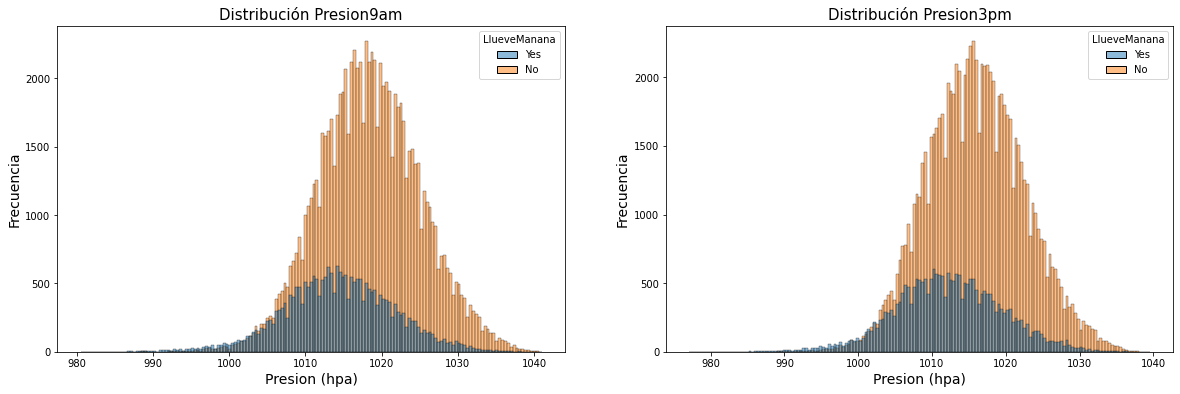

In [12]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
# distribucion para Presion9am
ax = sns.histplot(data=df, x="Presion9am", hue="LlueveManana", ax=axes[0])
ax.set_title('Distribución Presion9am',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Presion (hpa)',fontsize=14)
# distribucion para Presion3pm
ax = sns.histplot(data=df, x="Presion3pm", hue="LlueveManana", ax=axes[1])
ax.set_title('Distribución Presion3pm',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Presion (hpa)',fontsize=14);

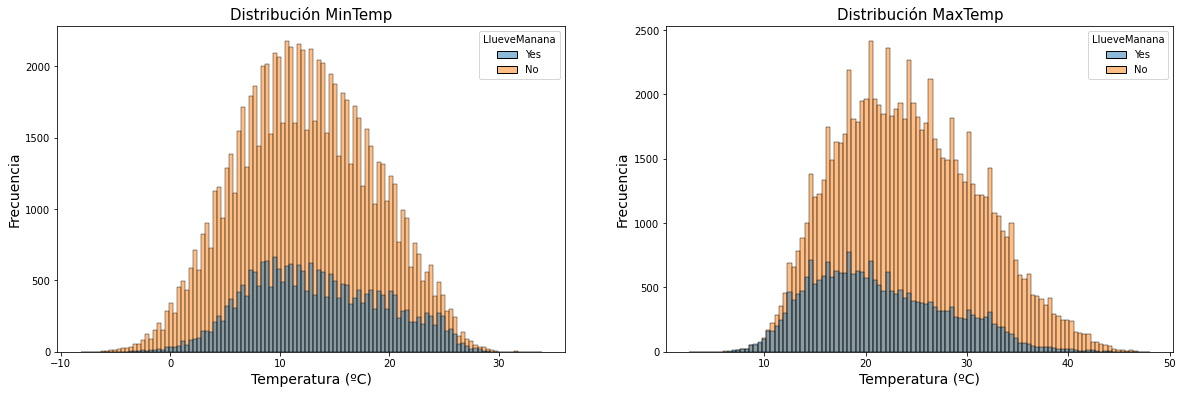

In [13]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
# distribucion para MinTemp
ax = sns.histplot(data=df, x="MinTemp", hue="LlueveManana", ax=axes[0])
ax.set_title('Distribución MinTemp',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Temperatura (ºC)',fontsize=14)
# distribucion para MaxTemp
ax = sns.histplot(data=df, x="MaxTemp", hue="LlueveManana", ax=axes[1])
ax.set_title('Distribución MaxTemp',fontsize=15)
ax.set_ylabel('Frecuencia',fontsize=14)
ax.set_xlabel('Temperatura (ºC)',fontsize=14);

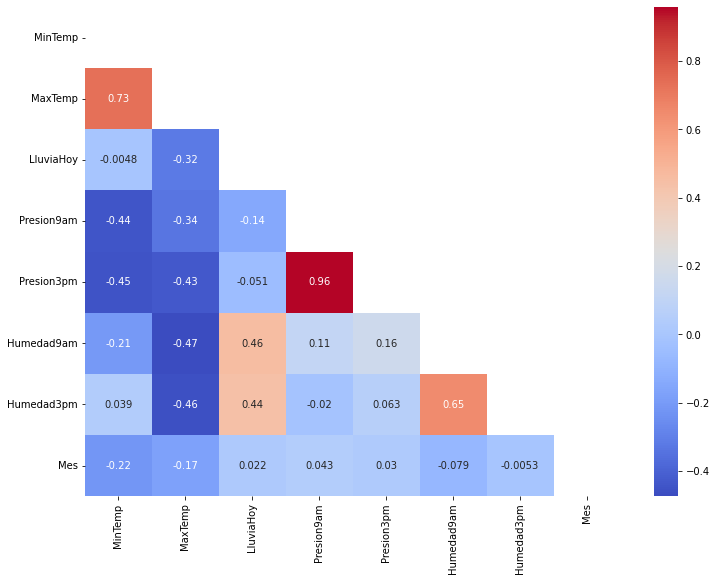

In [14]:
# matriz de correlación
plt.figure(figsize=(12,9))
# computamos matriz de correlación
corr_matrix = df.corr(method='spearman')
# esto nos permite graficar sólo la parte superior o inferior de la matriz
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# plot
sns.heatmap(corr_matrix,mask=mask,annot=True, cmap='coolwarm');

# **¿Cuál es el promedio de humedad a las 9 a.m en en los días en los que llueve al día siguiente?**

In [49]:
# seleccionamos los datos de humedad a las 9 a.m y lluvia del día siguiente
humedad_lluvia = df.loc[df['LlueveManana'] == 'Si', ['Humedad9am', 'LlueveManana']]

# calculamos el promedio de humedad a las 9 a.m
promedio_humedad = humedad_lluvia['Humedad9am'].mean()

print(f"El promedio de humedad a las 9 a.m")
print(f"en los días en los que llueve al día siguiente es {promedio_humedad:.2f}")


El promedio de humedad a las 9 a.m en los días en los que llueve al día siguiente es nan


**Observaciones**:
- Se observa que en los meses de Junio y Julio (meses 6 y 7) es cuando más lluvia cae en promedio en las distintas localidades de Australia, por tanto, el més en el que se genera la predicción puede ser un atributo importante al momento de predecir si al día siguiente caerá lluvia.
- La temperatura mínima y máxima alcanzan su mínimo en el mes de Julio, es un comportamiento periodico a través de los años. Así mismo, en Enero se alcanzan las mayores temperaturas.
- El conjunto de datos es desbalanceado, esto ya que se observa que la cantidad de días en las que al día siguiente llueve es de 25.343, mientras que los días en los que al día siguiente no llueve es de 90.545.
- En aquellos días donde llueve al día siguiente, la humedad a las 9 a.m y a las 3 p.m es aparentemente mayor en comparación con aquellos días en los que no llueve al día siguiente.
- Existe una fuerte correlación entre la presión atmosférica a las 9.00 a.m y a las 3.00 p.m

***
# Desafío

Tal como se adelantó al comienzo, el objetivo de este desafío es predecir si al siguiente día lloverá o no, para cada una de las localidades en Australia, en función de las características observables del día (presión atmosférica, humedad, temperatura mínima y máxima, etc.). Para esto se le solicita que entrene un clasificador de su elección utilizando la librería scikit-learn. Además, como parte de la evaluación de este módulo se le solicita que responda las siguientes preguntas:

1. ¿Cuál es el promedio de humedad a las 9 a.m en en los días en los que llueve al día siguiente?
2. ¿Considera que aún existen valores extremos u outliers en el conjunto de datos?
4. ¿Se debe mantener todas las variables dentro del dataset, o se deberían descartar algunas?
5. En base a los gráficos de distribución presentandos: ¿Qué variable considera que posee el mayor poder predictivo?

Finalmente, se le pide predecir si lloverá al día siguiente para las 10 observaciones del dataset `predict` disponible en el dataframe que se presenta a continuación. Notar que este dataframe posee lo mismos atributos que el dataset cargado al comienzo, con las salvedades de que se agregó una columna llamada `ID` para identificar cada una de las predicciones, y que en la columna `LlueveManana`, no hay valores.

In [42]:
#df.drop('Fecha', axis=1, inplace=True)
#df.drop('DirViento9am', axis=1, inplace=True)
#df.drop('DirViento3pm', axis=1, inplace=True)

df.head()

,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,LlueveManana,Mes
0,8.0,24.3,0.0,1019.7,1015.0,68.0,29.0,Yes,11
1,14.0,26.9,3.6,1012.4,1008.4,80.0,36.0,Yes,11
2,13.7,23.4,3.6,1009.5,1007.2,82.0,69.0,Yes,11
4,7.6,16.1,2.8,1018.3,1018.5,68.0,49.0,No,11
5,6.2,16.9,0.0,1023.8,1021.7,70.0,57.0,No,11


In [43]:
#CODIGO TEST 

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

X = df.drop('LlueveManana', axis=1)
y = df['LlueveManana']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Construir pipeline de preprocesamiento y modelo
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = numeric_transformer

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])



# Entrenar modelo

clf.fit(X_train, y_train)

# Realizar predicciones sobre conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular precisión
accuracy = clf.score(X_test, y_test)
print(f'Precisión del modelo: {accuracy:.2f}')



Precisión del modelo: 0.84


In [45]:
predict = pd.read_csv("https://raw.githubusercontent.com/ssantanar/datasets/master/weather_australia/weatherAUS_predict.csv", sep=';')
predict = predict.reset_index().rename(columns={'index':'ID'})
predict

,ID,Fecha,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,DirViento9am,DirViento3pm,LlueveManana
0,0,25-06-17,2.4,10.6,0.2,1017.5,1015.8,100.0,84.0,N,WNW,NaN
1,1,25-06-17,5.5,13.9,0.0,1017.8,1015.5,72.0,58.0,N,NW,NaN
2,2,25-06-17,7.6,19.3,0.0,1018.6,1015.4,73.0,32.0,W,W,NaN
3,3,25-06-17,5.7,12.6,0.0,1003.8,1002.2,75.0,67.0,NNW,NNW,NaN
4,4,25-06-17,6.8,19.5,0.0,1018.4,1015.2,67.0,42.0,NW,WSW,NaN
5,5,25-06-17,-0.1,12.7,0.0,1020.8,1018.5,92.0,54.0,SSW,SSE,NaN
6,6,25-06-17,9.3,15.4,7.4,1028.7,1026.7,100.0,70.0,WNW,SSW,NaN
7,7,25-06-17,14.8,20.1,3.8,1015.1,1014.2,85.0,69.0,SW,SSW,NaN
8,8,25-06-17,8.5,19.3,0.0,1020.2,1017.0,83.0,61.0,WSW,NNE,NaN
9,9,25-06-17,16.5,25.8,0.0,1018.1,1015.7,61.0,53.0,SE,ENE,NaN


In [46]:
#normalizamos  la fecha al formato de la tabla original y creamos el campo mes
predict['Fecha'] = pd.to_datetime(predict['Fecha'], format='%d-%m-%y')
predict['Mes'] = predict.Fecha.dt.month


# eliminamos columna Fecha y DirViento9am
predict = predict.drop(['Fecha', 'DirViento9am','DirViento3pm'], axis=1)

predict

,ID,MinTemp,MaxTemp,LluviaHoy,Presion9am,Presion3pm,Humedad9am,Humedad3pm,LlueveManana,Mes
0,0,2.4,10.6,0.2,1017.5,1015.8,100.0,84.0,NaN,6
1,1,5.5,13.9,0.0,1017.8,1015.5,72.0,58.0,NaN,6
2,2,7.6,19.3,0.0,1018.6,1015.4,73.0,32.0,NaN,6
3,3,5.7,12.6,0.0,1003.8,1002.2,75.0,67.0,NaN,6
4,4,6.8,19.5,0.0,1018.4,1015.2,67.0,42.0,NaN,6
5,5,-0.1,12.7,0.0,1020.8,1018.5,92.0,54.0,NaN,6
6,6,9.3,15.4,7.4,1028.7,1026.7,100.0,70.0,NaN,6
7,7,14.8,20.1,3.8,1015.1,1014.2,85.0,69.0,NaN,6
8,8,8.5,19.3,0.0,1020.2,1017.0,83.0,61.0,NaN,6
9,9,16.5,25.8,0.0,1018.1,1015.7,61.0,53.0,NaN,6


In [48]:
predict = predict.drop(['ID', 'LlueveManana'], axis=1)

# reemplazar valores faltantes con la mediana
predict = predict.fillna(predict.median())

# predecir LlueveManana
predictions = clf.predict(predict)

# agregar las predicciones al dataframe predict
predict['LlueveManana'] = predictions

# mostrar el dataframe con las predicciones
print(predict)

   MinTemp  MaxTemp  LluviaHoy  Presion9am  Presion3pm  Humedad9am  \
0      2.4     10.6        0.2      1017.5      1015.8       100.0   
1      5.5     13.9        0.0      1017.8      1015.5        72.0   
2      7.6     19.3        0.0      1018.6      1015.4        73.0   
3      5.7     12.6        0.0      1003.8      1002.2        75.0   
4      6.8     19.5        0.0      1018.4      1015.2        67.0   
5     -0.1     12.7        0.0      1020.8      1018.5        92.0   
6      9.3     15.4        7.4      1028.7      1026.7       100.0   
7     14.8     20.1        3.8      1015.1      1014.2        85.0   
8      8.5     19.3        0.0      1020.2      1017.0        83.0   
9     16.5     25.8        0.0      1018.1      1015.7        61.0   

   Humedad3pm  Mes LlueveManana  
0        84.0    6          Yes  
1        58.0    6           No  
2        32.0    6           No  
3        67.0    6          Yes  
4        42.0    6           No  
5        54.0    6       